In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline.load import load_data
from reproduction import analysis
import sklearn

In [3]:
from reproduction.pipeline import into_record

In [4]:
from scipy import fftpack
from matplotlib.colors import LogNorm

In [5]:
from scipy.stats import wasserstein_distance

In [6]:
from scipy.spatial.distance import cosine

In [7]:
import itertools

In [114]:
from sklearn.manifold import TSNE

In [8]:
# open/closed cell data dir
CLOSEDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_close"
CLOSEDS = CLOSEDATADIR+"/closed.tfrecord"
OPENDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_open"
OPENS = OPENDATADIR+"/open.tfrecord"

# same brightness but no texture to open/closed cell data dir
BCLOSEDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN30MOD09GA_ambiguous_closed"
BCLOSEDS = BCLOSEDATADIR+"/bright_closed.tfrecord"
BOPENDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN31MOD09GA_ambiguous_open"
BOPENS = BOPENDATADIR+"/bright_open.tfrecord"

# outputdata dir
OUTPUTDIR="/project/foster/clouds/output"
CENTERS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc.cluster_centres"
ENCODER_DEF = OUTPUTDIR+"/mod09cnn15b/encoder.json"
ENCODER_WEIGHTS = OUTPUTDIR+"/mod09cnn15b/encoder-585000.h5"
ENCODINGS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc"

In [9]:
centers = analysis.read_kmeans_centers(CENTERS)

In [10]:
k = KMeans(n_clusters=centers.shape[0], init=centers)

In [11]:
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

In [12]:
N=30  # number of patches
opens = analysis.AEData(load_data(OPENS, encoder.input_shape[1:], repeat=False), n=N)
closeds = analysis.AEData(load_data(CLOSEDS, encoder.input_shape[1:], repeat=False), n=N)
bopens = analysis.AEData(load_data(BOPENS, encoder.input_shape[1:], repeat=False), n=N)
bcloseds = analysis.AEData(load_data(BCLOSEDS, encoder.input_shape[1:], repeat=False), n=N)

In [13]:
opens.add_encoder(encoder)
closeds.add_encoder(encoder)
bopens.add_encoder(encoder)
bcloseds.add_encoder(encoder)

## Image Data

In [14]:
# TODO: include in analysis.py 
def _get_imgs(dataset, ae=None, fields=None, n=500):
        # get data from dataset
        names, coords, imgs = [], [], []
        batch = dataset.make_one_shot_iterator().get_next()
        with tf.Session() as sess:
            while len(imgs) < n:
                names_, coords_, imgs_ = sess.run(batch)
                names.extend(names_)
                coords.extend(coords_)
                imgs.extend(imgs_)
        return imgs

In [15]:
oimgs = _get_imgs(load_data(OPENS, encoder.input_shape[1:], repeat=False), n=30)
cimgs = _get_imgs(load_data(CLOSEDS, encoder.input_shape[1:], repeat=False), n=30)
_oimgs = _get_imgs(load_data(BOPENS, encoder.input_shape[1:], repeat=False), n=30)
_cimgs = _get_imgs(load_data(BCLOSEDS, encoder.input_shape[1:], repeat=False), n=30)

In [16]:
oimgs_array = np.asarray(oimgs)
cimgs_array = np.asarray(cimgs)
_oimgs_array = np.asarray(_oimgs)
_cimgs_array = np.asarray(_cimgs)

In [18]:
oimgs_array.shape

(32, 128, 128, 7)

## Cluster

In [17]:
#  cluster
k.cluster_centers_ = centers
# Number of Clusters 
num_clusters = 10
# Append
oc = np.append(opens.encs,closeds.encs, axis=0)
boc = np.append(bopens.encs,bcloseds.encs, axis=0)
both = np.append(oc, boc,  axis=0)

In [18]:
method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = method.fit_predict(both)
o, c, bo, bc = clusters[:N], clusters[N:N*2], clusters[N*2:N*3], clusters[N*3:]

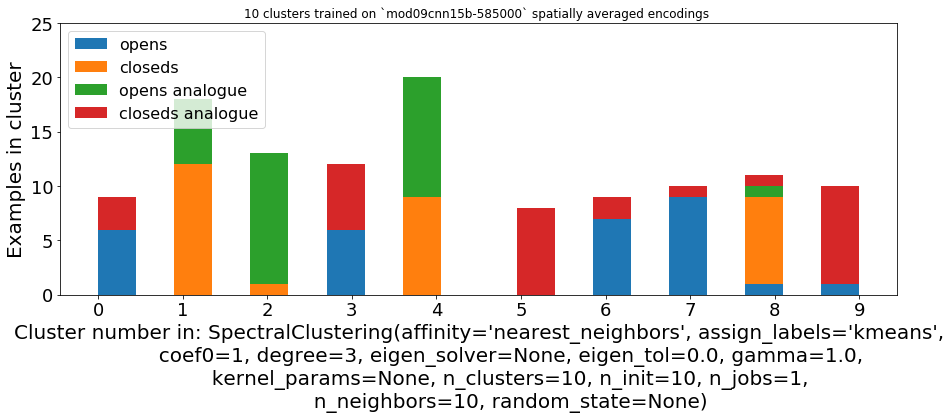

In [19]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([0,5,10,15,20, 25])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)

================ 12/12 =================================

# Cosine similarity

Compute cosine similarity 
range 0 - 1 in cosine anguler. 1 is highest similarity, but 0 is lowest similarity 

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.

spectral clustering makes use of eigencalue, so considering latent vectors is correct?
--> check spectrak clustering

### Check individual cases

In [20]:
def _prep_cos(current_cluster, xcluster, ycluster, x_ae, y_ae):
    xid = np.argwhere(xcluster==current_cluster)
    yid = np.argwhere(ycluster==current_cluster)
    # get latent list
    x_list, y_list = [], []
    for i in xid:
        
        x_list += [x_ae.encs[i[0]]]
    for j in yid:
        y_list += [y_ae.encs[j[0]]]
    return x_list, y_list

In [21]:
# check shape encs
closeds.encs.shape

(30, 128)

In [22]:
closeds.encs[0].shape

(128,)

In [23]:
cluster = 4
c_list, bo_list = _prep_cos(cluster, c,bo,closeds, bopens)

In [24]:
# check shape
len(c_list[0])

128

In [25]:
cs = [ cosine(x,y) for x in c_list for y in bo_list if x is not y]

(array([16., 32., 21., 11.,  3.,  5.,  5.,  4.,  1.,  1.]),
 array([0.00253159, 0.00364446, 0.00475733, 0.00587021, 0.00698308,
        0.00809595, 0.00920882, 0.01032169, 0.01143457, 0.01254744,
        0.01366031]),
 <a list of 10 Patch objects>)

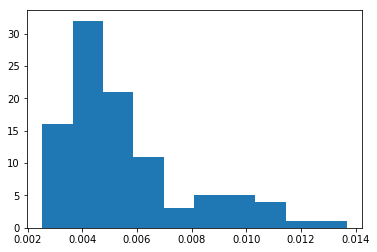

In [26]:
plt.hist(cs)

(array([4., 6., 4., 8., 2., 5., 1., 2., 3., 1.]),
 array([0.00522089, 0.00632988, 0.00743887, 0.00854787, 0.00965686,
        0.01076585, 0.01187484, 0.01298383, 0.01409283, 0.01520182,
        0.01631081]),
 <a list of 10 Patch objects>)

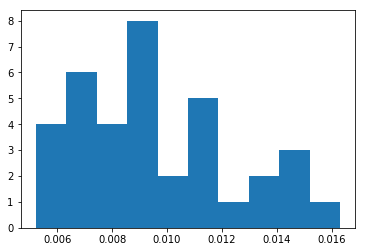

In [27]:
cluster = 3
o_list, bc_list = _prep_cos(cluster, o,bc,opens, bcloseds)
cs1 = [ cosine(x,y) for x in o_list for y in bc_list if x is not y]
plt.hist(cs1)

(array([2., 2., 3., 1., 3., 0., 2., 0., 2., 3.]),
 array([0.00473875, 0.00625854, 0.00777833, 0.00929813, 0.01081792,
        0.01233771, 0.01385751, 0.0153773 , 0.01689709, 0.01841689,
        0.01993668]),
 <a list of 10 Patch objects>)

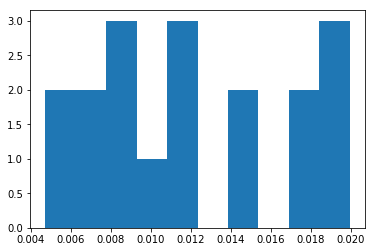

In [28]:
cluster = 0
o_list, bc_list = _prep_cos(cluster, o,bc,opens, bcloseds)
cs1 = [ cosine(x,y) for x in o_list for y in bc_list if x is not y]
plt.hist(cs1)

(array([12., 19., 16.,  7.,  6.,  7.,  2.,  1.,  1.,  1.]),
 array([0.00186366, 0.00286745, 0.00387125, 0.00487505, 0.00587884,
        0.00688264, 0.00788643, 0.00889023, 0.00989403, 0.01089782,
        0.01190162]),
 <a list of 10 Patch objects>)

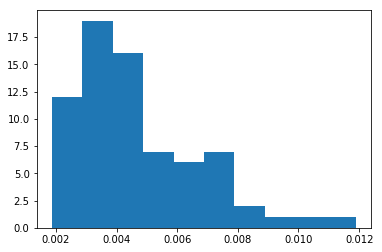

In [29]:
cluster = 1
c_list, bo_list = _prep_cos(cluster, c,bo,closeds, bopens)
cs6 = [ cosine(x,y) for x in c_list for y in bo_list if x is not y]
plt.hist(cs6)

(array([1., 2., 0., 4., 2., 1., 0., 1., 1., 2.]),
 array([0.0408287 , 0.04582579, 0.05082287, 0.05581995, 0.06081703,
        0.06581411, 0.07081119, 0.07580827, 0.08080535, 0.08580243,
        0.09079951]),
 <a list of 10 Patch objects>)

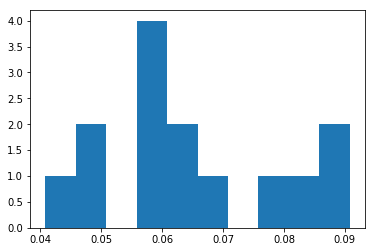

In [30]:
cluster = 6
o_list, bc_list = _prep_cos(cluster, o,bc,opens, bcloseds)
cs1 = [ cosine(x,y) for x in o_list for y in bc_list if x is not y]
plt.hist(cs1)

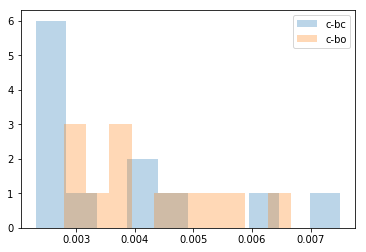

In [31]:
cluster = 8
o_list, bc_list = _prep_cos(cluster, o,bc,opens, bcloseds)
b_list, bo_list = _prep_cos(cluster, c,bo,closeds, bopens)
cs0c = [ cosine(x,y) for x in c_list for y in bc_list if x is not y]
cs0o = [ cosine(x,y) for x in o_list for y in bo_list if x is not y]
cs0bc = [ cosine(x,y) for x in o_list for y in bc_list if x is not y]
cs0bo = [ cosine(x,y) for x in c_list for y in bo_list if x is not y]
plt.hist(cs0c, alpha=0.3, label='c-bc')
plt.hist(cs0bo, alpha=0.3, label='c-bo')
plt.legend()

[0.009280741214752197] [0.0073508620262146]


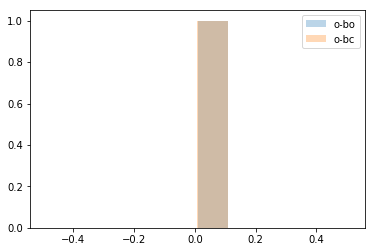

In [32]:
plt.hist(cs0o, alpha=0.3, label='o-bo')
plt.hist(cs0bc, alpha=0.3, label='o-bc')
print(cs0o, cs0bc)
plt.legend()

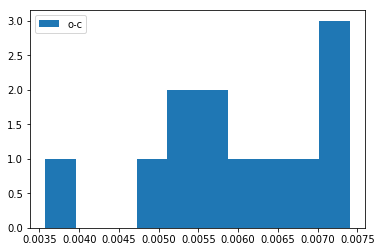

In [33]:
cs0co = [ cosine(x,y) for x in c_list for y in o_list if x is not y]
plt.hist(cs0co, label='o-c')
plt.legend()

#### intra cluster's distribution of cosine value 

In [61]:
_x0 =[ 0, [o,bc] ,[opens, bcloseds]]
_x1 =[ 1, [c,bo] ,[closeds, bopens]]
_x2 =[ 2, [c,bo] ,[closeds, bopens]]
_x3 =[ 3, [o,bc] ,[opens, bcloseds]]
_x4 =[ 4, [c,bo] ,[closeds, bopens]]
_x6 =[ 6, [o,bc] ,[opens, bcloseds]]
_x7 =[ 7, [o,bc] ,[opens, bcloseds]]
_x9 =[ 9, [o,bc] ,[opens, bcloseds]]

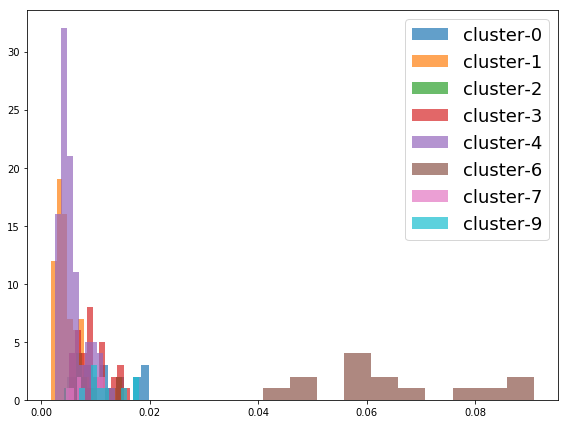

In [75]:
fig = plt.figure(figsize=(8,6))
ccs = []
alist = [_x0,_x1,_x2,_x3,_x4,_x6,_x7,_x9]
for indx, i in enumerate([_x0,_x1,_x2,_x3,_x4,_x6,_x7,_x9]):
    idx = i[0]
    clusters = i[1]
    aes = i[2]
    _xs, _ys = _prep_cos(idx, clusters[0], clusters[1], aes[0], aes[1])
    ccs += [ [ cosine(x,y) for x in _xs for y in _ys if x is not y] ]

for indx , i in enumerate(ccs):
    if not alist[indx][0] == 9:
        plt.hist(i, alpha=0.7, label='cluster-'+str(alist[indx][0]))
    else:
        plt.hist(i, alpha=0.7, label='cluster-'+str(alist[indx][0]), color='#17becf')
fig.tight_layout()
plt.legend(fontsize=18)
plt.show()

#### Cosine similarity in total dataset

In [34]:
def _total_list(x_ae):
    x_list = []
    for i in range(30):
        x_list += [x_ae.encs[i]]
    return x_list

In [35]:
xc_list  = _total_list(closeds)
xo_list  = _total_list(opens)
xbc_list = _total_list(bcloseds)
xbo_list = _total_list(bopens) 

In [36]:
len(list(itertools.permutations([xc_list,xo_list, xbc_list, xbo_list], 2)))

12

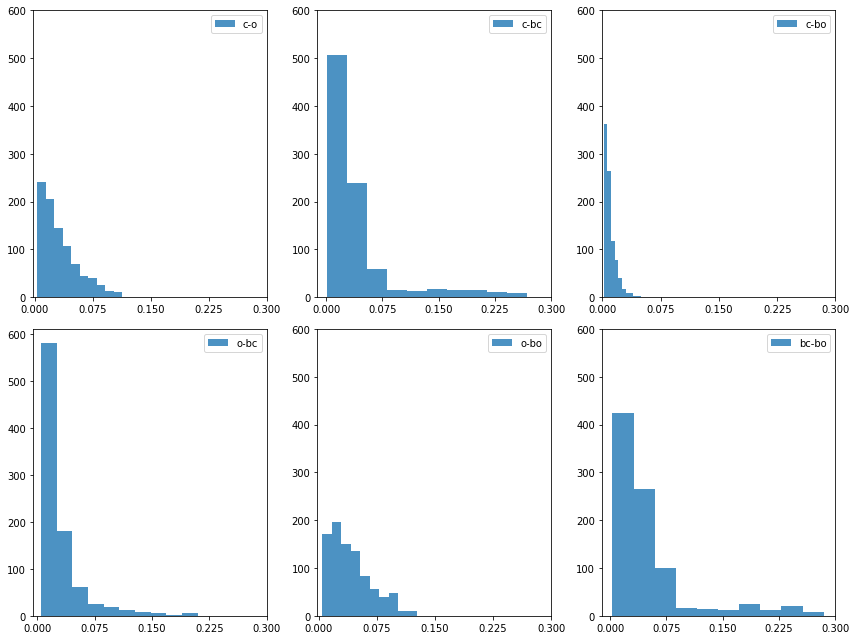

In [60]:
fig = plt.figure(figsize=(12,9))
icount = 0
for (i, j), (iname, jname) in zip(itertools.combinations_with_replacement([xc_list,xo_list, xbc_list, xbo_list], 2),
                              itertools.combinations_with_replacement(['c','o', 'bc', 'bo'], 2)):
    #print(iname, jname)
    #if iname == 'c' or jname == 'c':
    #    ci = '#1f77b4'; cj = '#1f77b4'
    #elif iname == 'o' or jname == 'o':
    if iname is not jname:
        ax = plt.subplot(2,3,icount+1)
        _cs = [ cosine(x,y) for x in i for y in j if x is not y]    
        ax.hist(_cs, alpha=0.8, label=iname+'-'+jname)
        icount += 1
        plt.legend()
        plt.xticks(np.linspace(0.0,0.3,5))
        plt.yticks(range(0,600+1,100))
fig.tight_layout()
plt.show()

# Plot Images in each cluster

In [103]:
def _plot_in_cluster(x, x_array,cluster=100, cloud_type='XXX'):
    '''x = X.encs
       x_array = image
    '''
    fig = plt.figure(figsize=(12,9))
    icount = 0
    row = int(len(np.argwhere(x == cluster))/4)+1
    print('### Cloud Label == %s' %cloud_type)
    for ix , i in enumerate(np.argwhere(x == cluster)):
        ax=plt.subplot(row,4,icount+1)
        ax.set_title(' %d th cluster' %cluster)
        plt.imshow(x_array[i[0],:,:,0], norm=None, cmap="bone")
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    plt.show()

## Cluster 0

### Cloud Label == opends


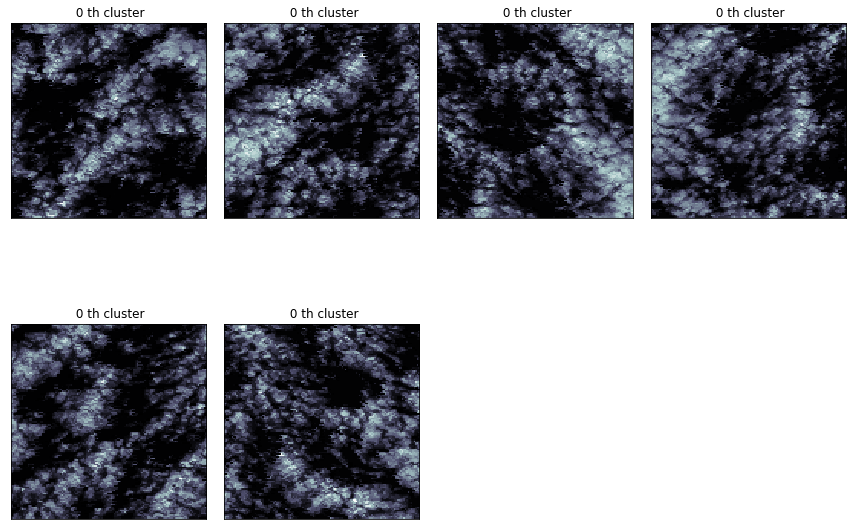

In [104]:
_plot_in_cluster( o, oimgs_array,cluster=0, cloud_type='opends')

### Cloud Label == closed analogue


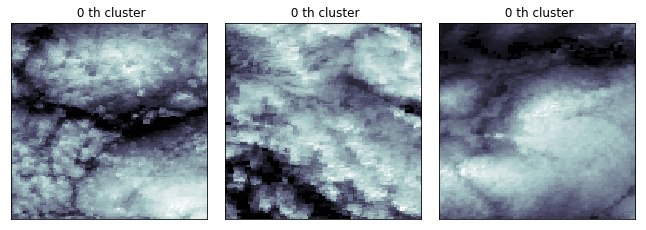

In [106]:
_plot_in_cluster( bc, _cimgs_array,cluster=0, cloud_type='closed analogue')

## Cluster 1

### Cloud Label == closeds


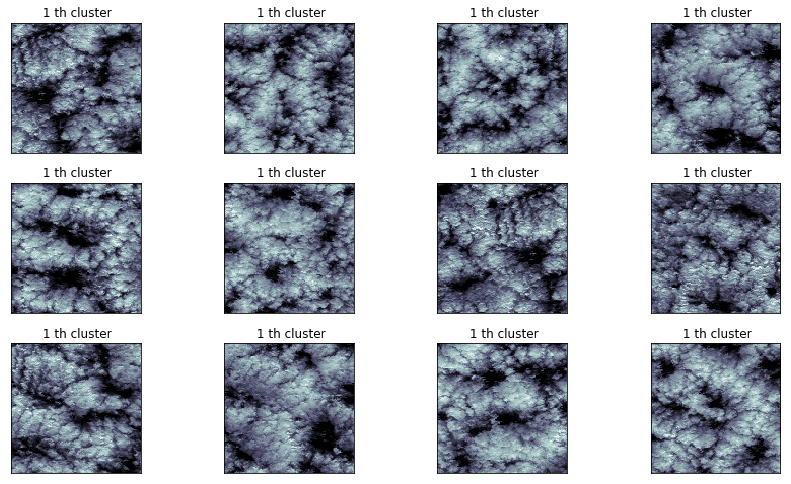

In [102]:
_plot_in_cluster( c, cimgs_array,cluster=1, cloud_type='closeds')

6
### Cloud Label == open analogue


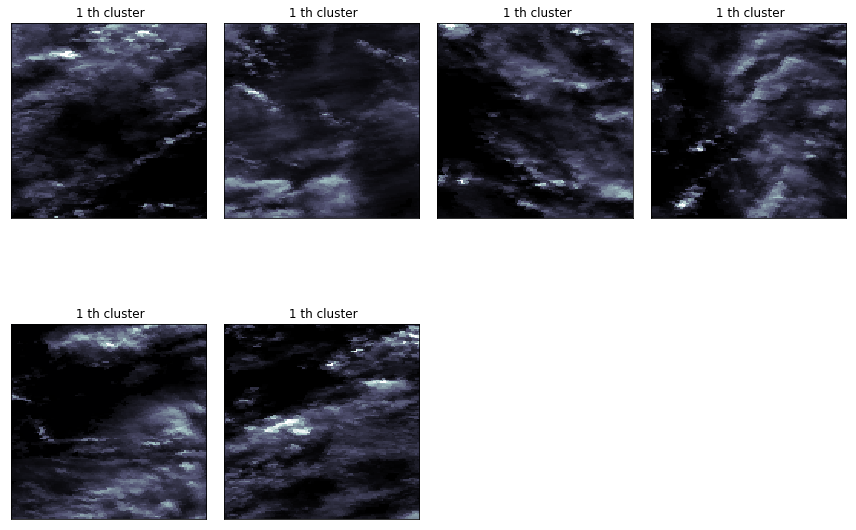

In [101]:
print(len(np.argwhere(bo == 1)))
_plot_in_cluster( bo, _oimgs_array,cluster=1, cloud_type='open analogue')

## Cluster 3 

### Cloud Label == opends


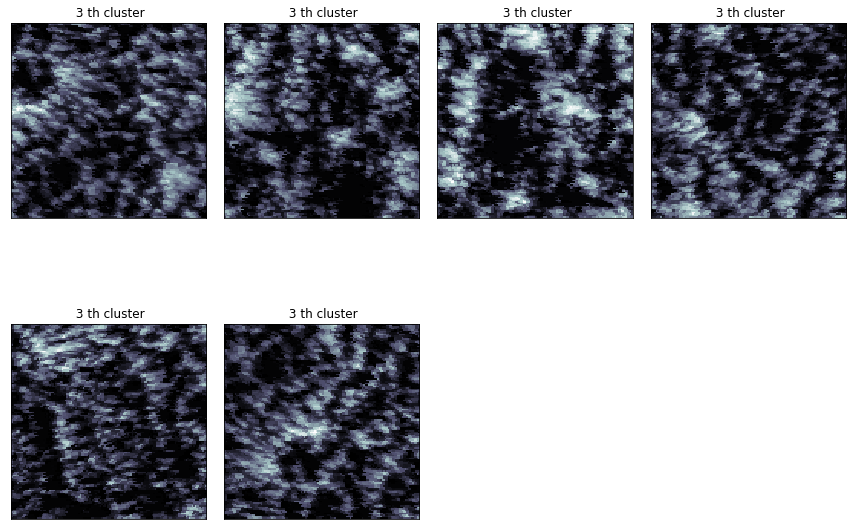

### Cloud Label == closed analogue


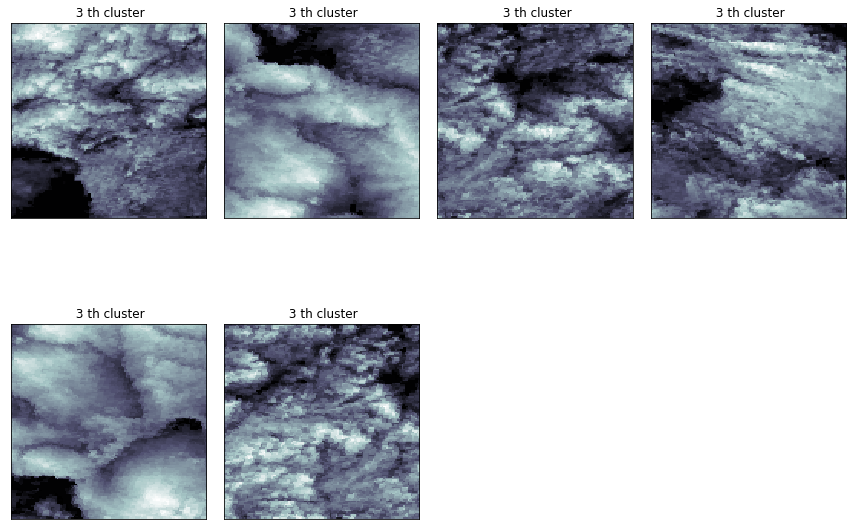

In [109]:
_plot_in_cluster( o, oimgs_array,cluster=3, cloud_type='opends')
_plot_in_cluster( bc, _cimgs_array,cluster=3, cloud_type='closed analogue')

## Cluster 4

### Cloud Label == closeds


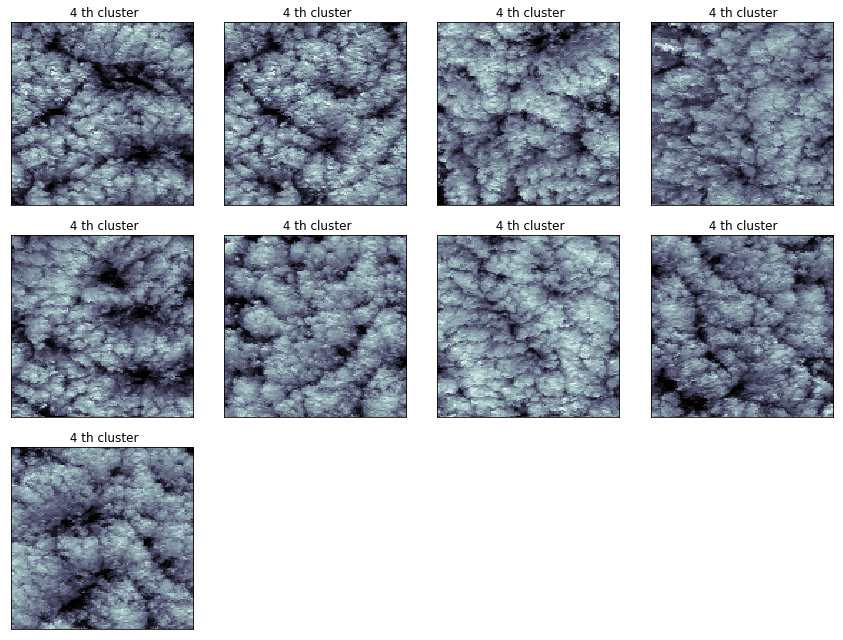

### Cloud Label == open analogue


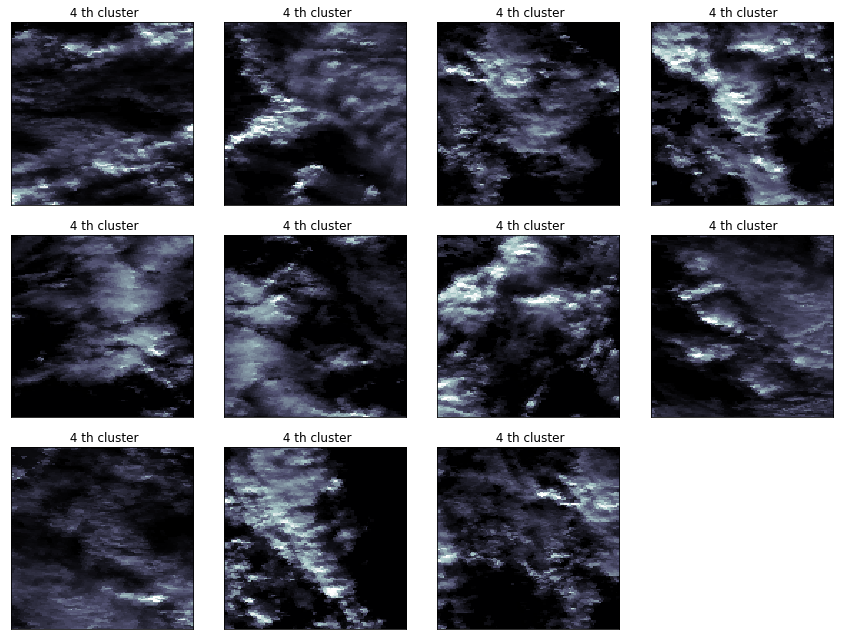

In [110]:
_plot_in_cluster( c, cimgs_array,cluster=4, cloud_type='closeds')
_plot_in_cluster( bo, _oimgs_array,cluster=4, cloud_type='open analogue')

## Cluster 6
this is the group that cosine distance is largest among clusters

### Cloud Label == opends


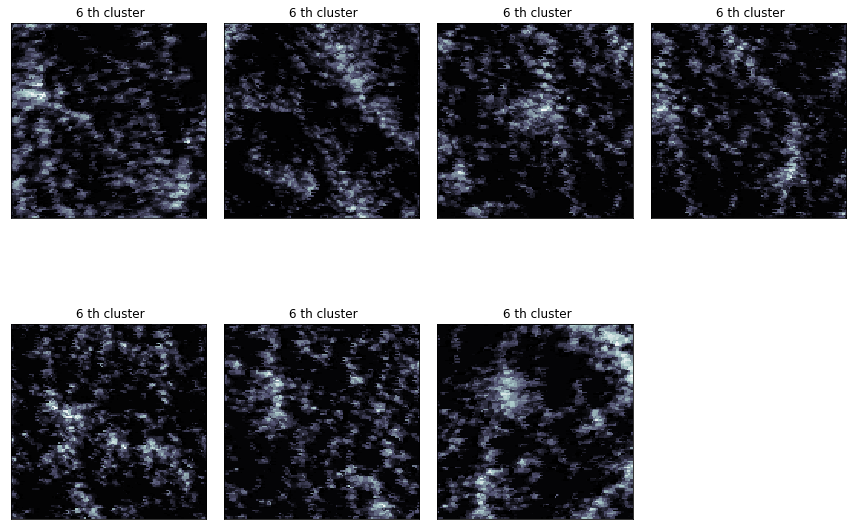

### Cloud Label == closed analogue


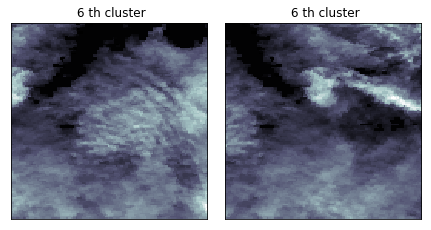

In [111]:
_plot_in_cluster( o, oimgs_array,cluster=6, cloud_type='opends')
_plot_in_cluster( bc, _cimgs_array,cluster=6, cloud_type='closed analogue')

## Cluster 8
only cluster where all 4 types are togather

### Cloud Label == closeds


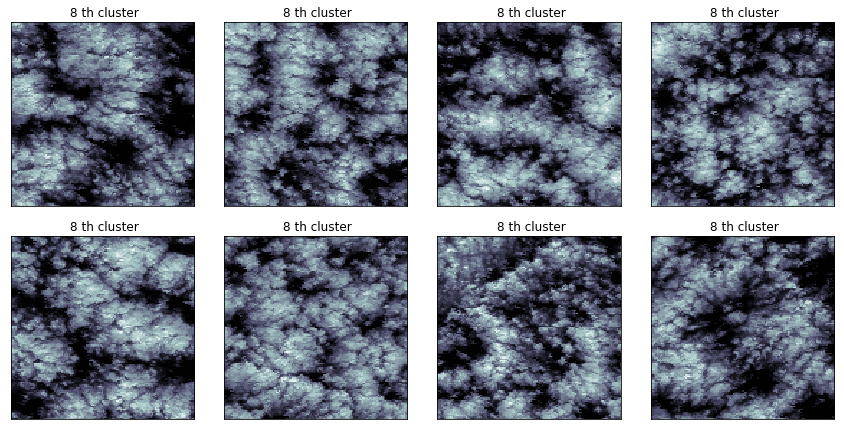

### Cloud Label == closed analogue


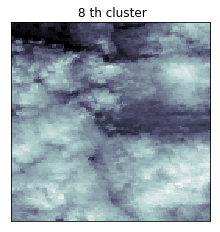

### Cloud Label == opends


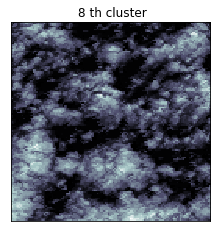

### Cloud Label == open analogue


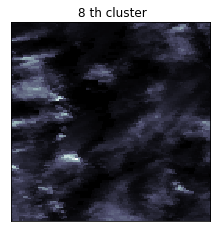

In [112]:
_plot_in_cluster( c, cimgs_array,cluster=8, cloud_type='closeds')
_plot_in_cluster( bc, _cimgs_array,cluster=8, cloud_type='closed analogue')
_plot_in_cluster( o, oimgs_array,cluster=8, cloud_type='opends')
_plot_in_cluster( bo, _oimgs_array,cluster=8, cloud_type='open analogue')

## t-SNE towards mixture cluster

In [186]:
def _plot_tsne( x,y,x_ae, y_ae, cluster=10, l1='XX open', l2 ='YY closed'):
    ''' x, y : cluster array
        x_ae : X.encs
        y_ae : Y.encs 
    '''
    fig = plt.figure(figsize=(12,9))
    cloud_type = l1+'-'+l2
    print(cluster)
    print('### Cloud Label == %s' %cloud_type)
    
    x_array = np.asarray(x_ae)
    y_array = np.asarray(y_ae)
    xidx = np.argwhere(x == cluster)
    yidx = np.argwhere(y == cluster)

    both = np.append(x_array, y_array, axis=0)
    embedded = TSNE(n_components=2).fit_transform(both)    
    print(embedded.shape)
 
    x0_list, x1_list =[], []
    y0_list, y1_list =[], []
    z0_list, z1_list =[], []
    #
    plt.figure(figsize=(12,9))
    ax = plt.subplot(111)
    for i in range(60):
        if i in  xidx  or i-30 in yidx:
            x0_list.append(embedded[i,0])
            x1_list.append(embedded[i,1])
        elif i < 30:
            y0_list.append(embedded[i,0])
            y1_list.append(embedded[i,1])
        else:
            z0_list.append(embedded[i,0])
            z1_list.append(embedded[i,1])
           
    print(len(x0_list))
    print(len(y0_list))
    print(len(z0_list))
    plt.scatter( x0_list, x1_list,label=str(cluster)+'th_'+l1+'-'+l2, color='#1f77b4')
    plt.scatter( y0_list, y1_list ,label='other_'+l1, color='#ff7f0e' )
    plt.scatter( z0_list, z1_list ,label='other_'+l2, color='#2ca02c' )
    fig.tight_layout()
    plt.legend(fontsize=15)
    plt.show()

1
### Cloud Label == closed-open analogue
(60, 2)
18
18
24


<Figure size 864x648 with 0 Axes>

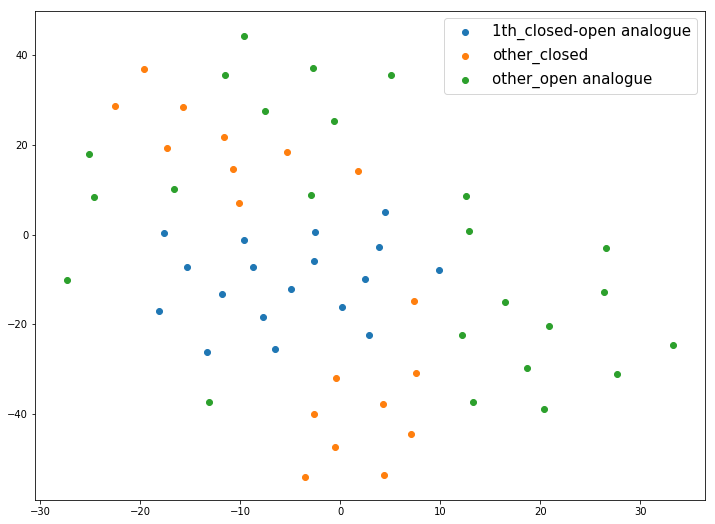

In [187]:
_plot_tsne(c, bo,closeds.encs,bopens.encs,cluster=1, l1='closed', l2 ='open analogue')

4
### Cloud Label == closed-open analogue
(60, 2)
20
21
19


<Figure size 864x648 with 0 Axes>

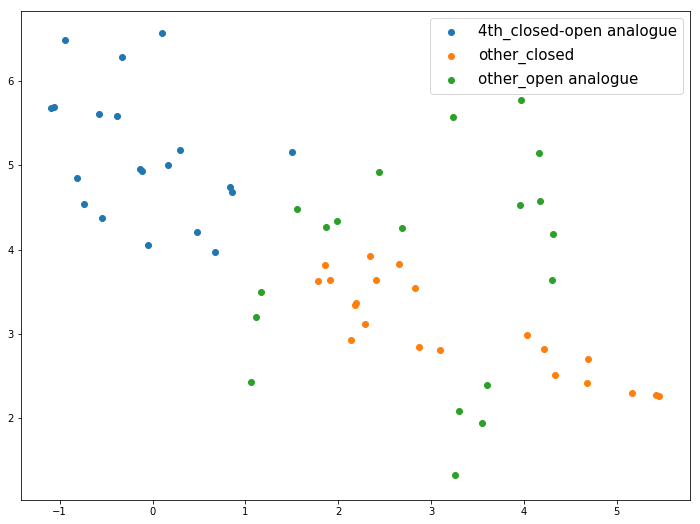

In [188]:
_plot_tsne(c, bo,closeds.encs,bopens.encs,cluster=4, l1='closed', l2 ='open analogue')

3
### Cloud Label == opens-closed analogue
(60, 2)
12
24
24


<Figure size 864x648 with 0 Axes>

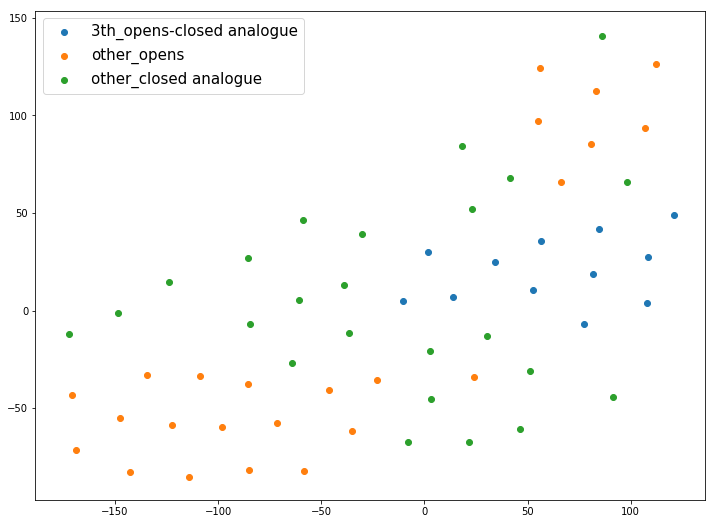

In [190]:
_plot_tsne(o, bc,opens.encs,bcloseds.encs,cluster=3, l1='opens', l2 ='closed analogue')

6
### Cloud Label == opens-closed analogue
(60, 2)
9
23
28


<Figure size 864x648 with 0 Axes>

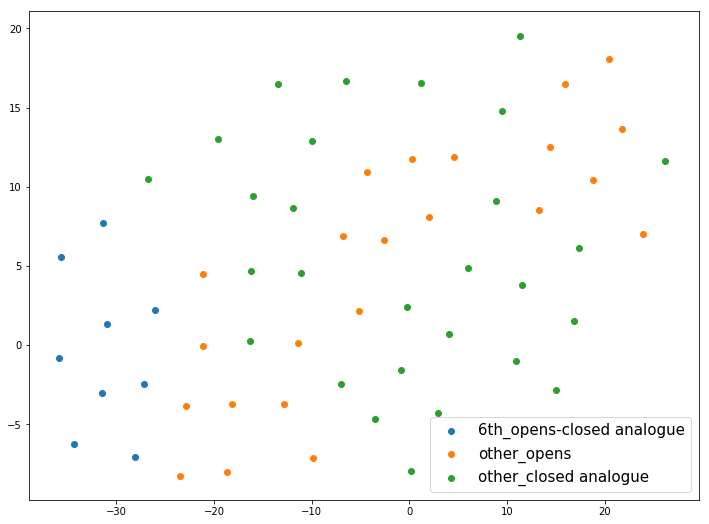

In [195]:
_plot_tsne(o, bc,opens.encs,bcloseds.encs,cluster=6, l1='opens', l2 ='closed analogue' )

0
### Cloud Label == opens-closed analogue
(60, 2)
9
24
27


<Figure size 864x648 with 0 Axes>

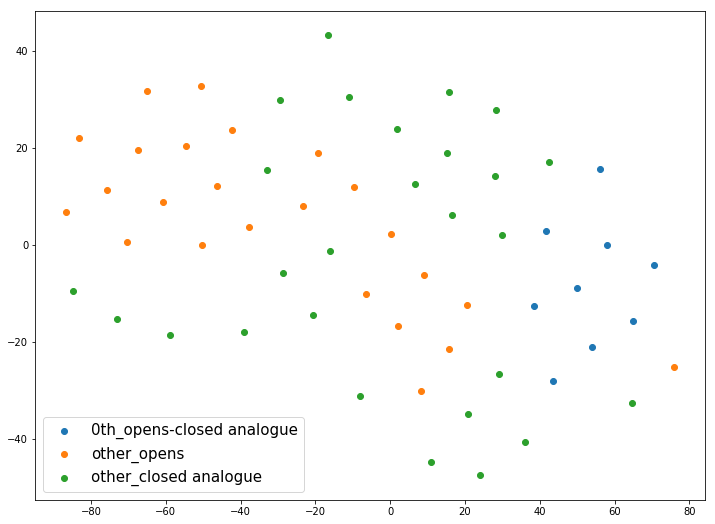

In [197]:
_plot_tsne(o, bc,opens.encs,bcloseds.encs,cluster=0, l1='opens', l2 ='closed analogue' )

# Plot Figures

============== Old 12/13 ==========================

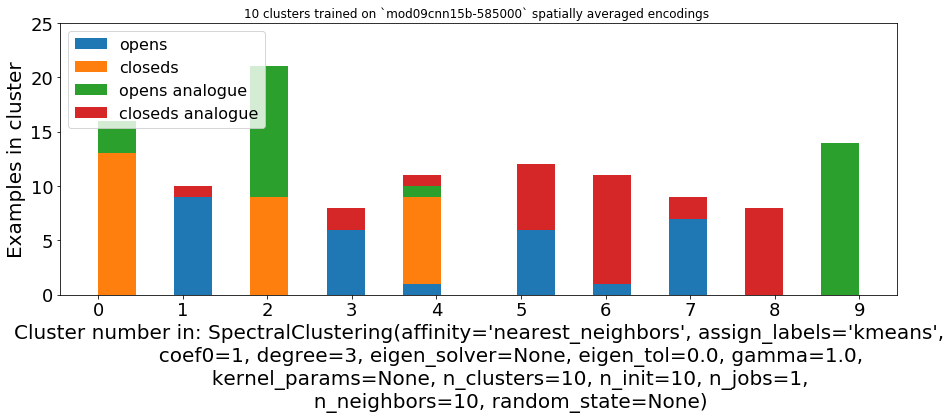

# Plot Other radiance

## Cluster ==5 Opens vs Closeds analogue 

6


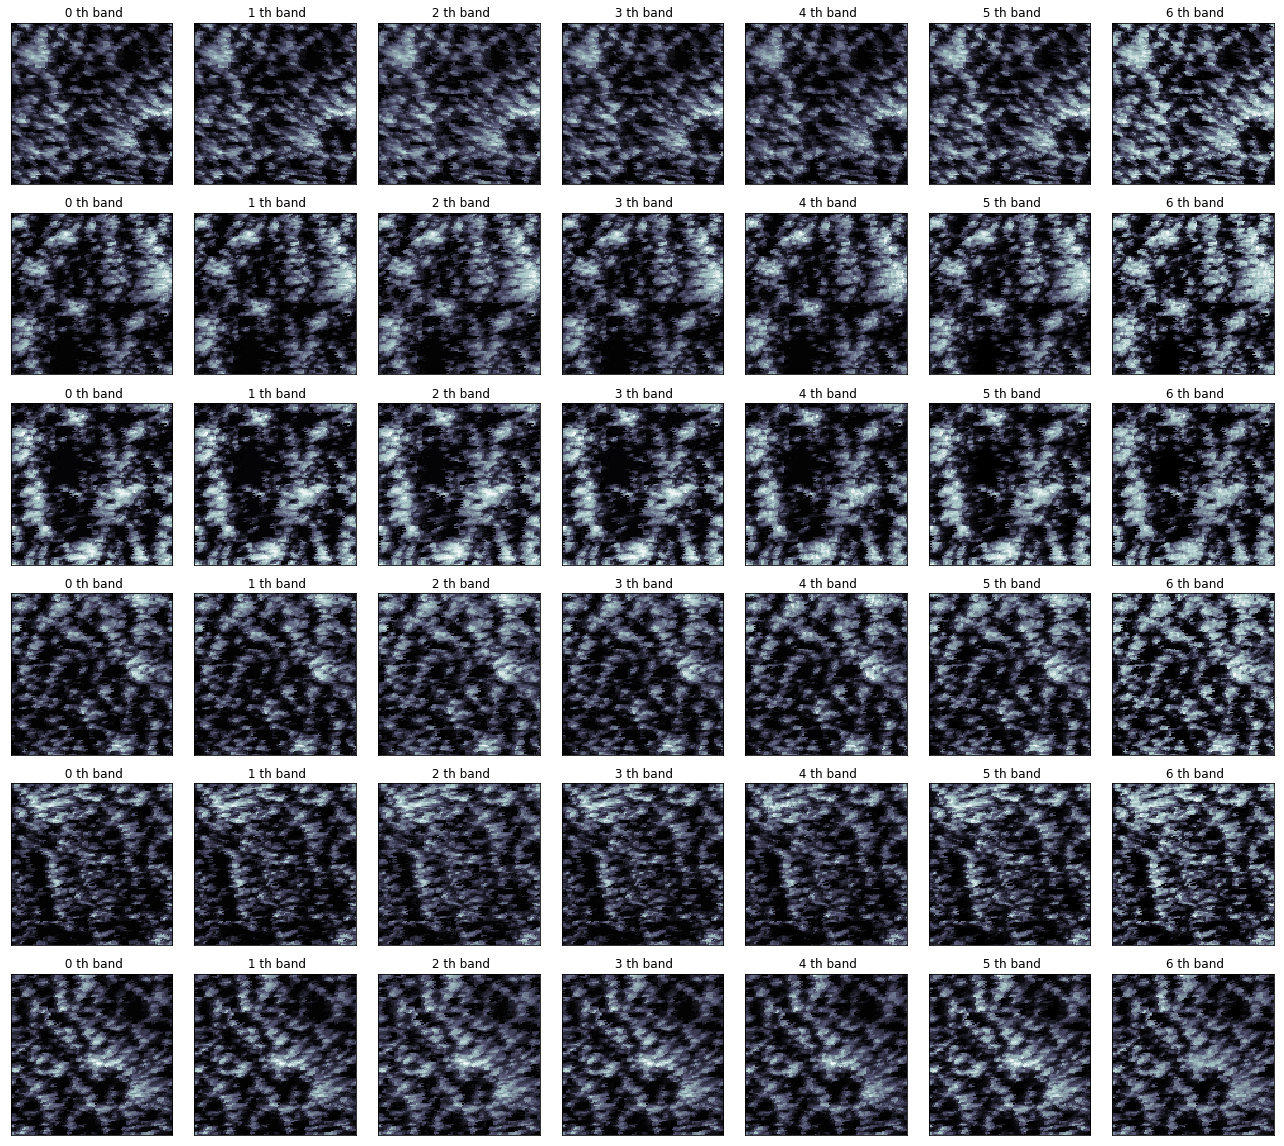

In [51]:
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(o == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(o == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(o == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        plt.imshow(oimgs_array[i[0],:,:,ir], norm=None, cmap="bone")
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

6


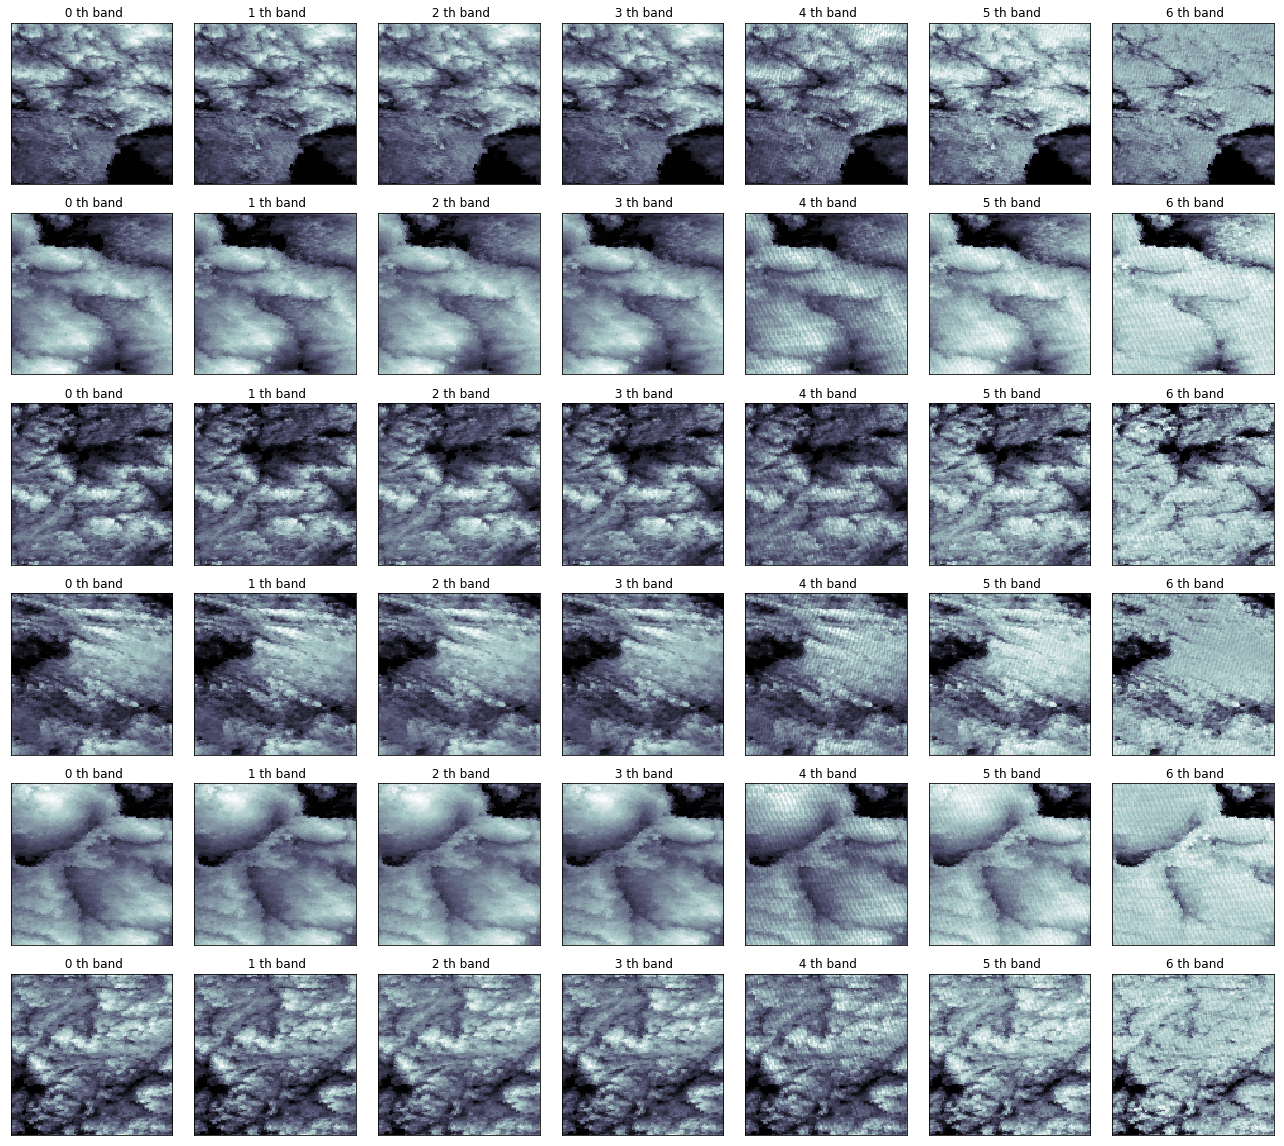

In [52]:
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(bc == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(bc == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(bc == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        plt.imshow(_cimgs_array[i[0],:,:,ir], norm=None, cmap="bone")
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

## Numerical check 

Histogram of original image

6


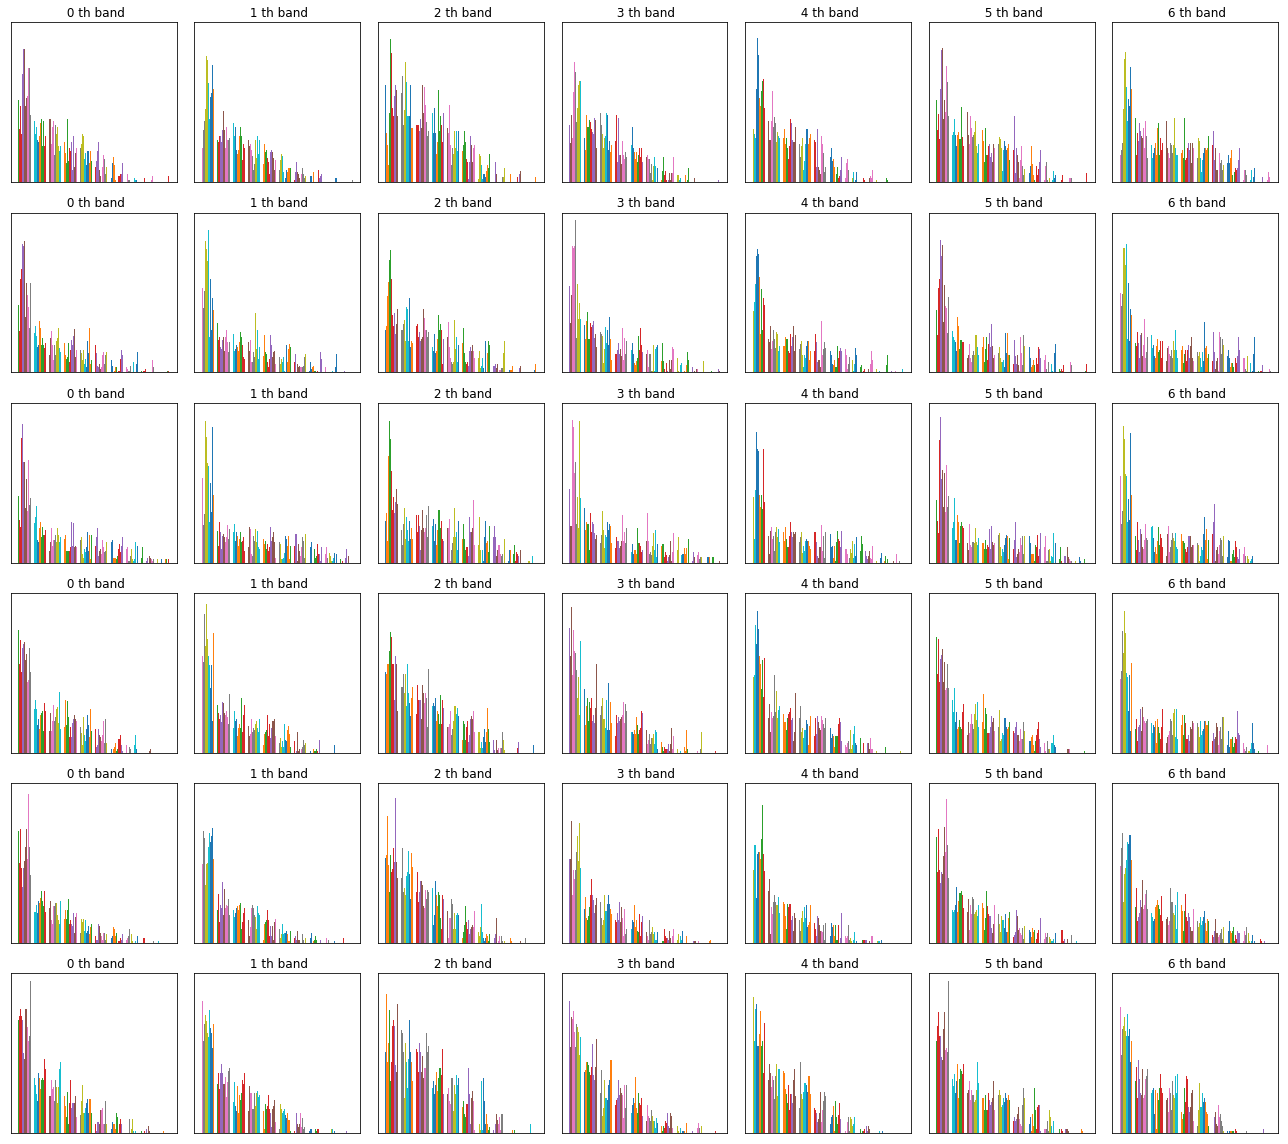

In [54]:
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(o == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(o == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(o == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        plt.hist(oimgs_array[i[0],:,:,ir])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

6


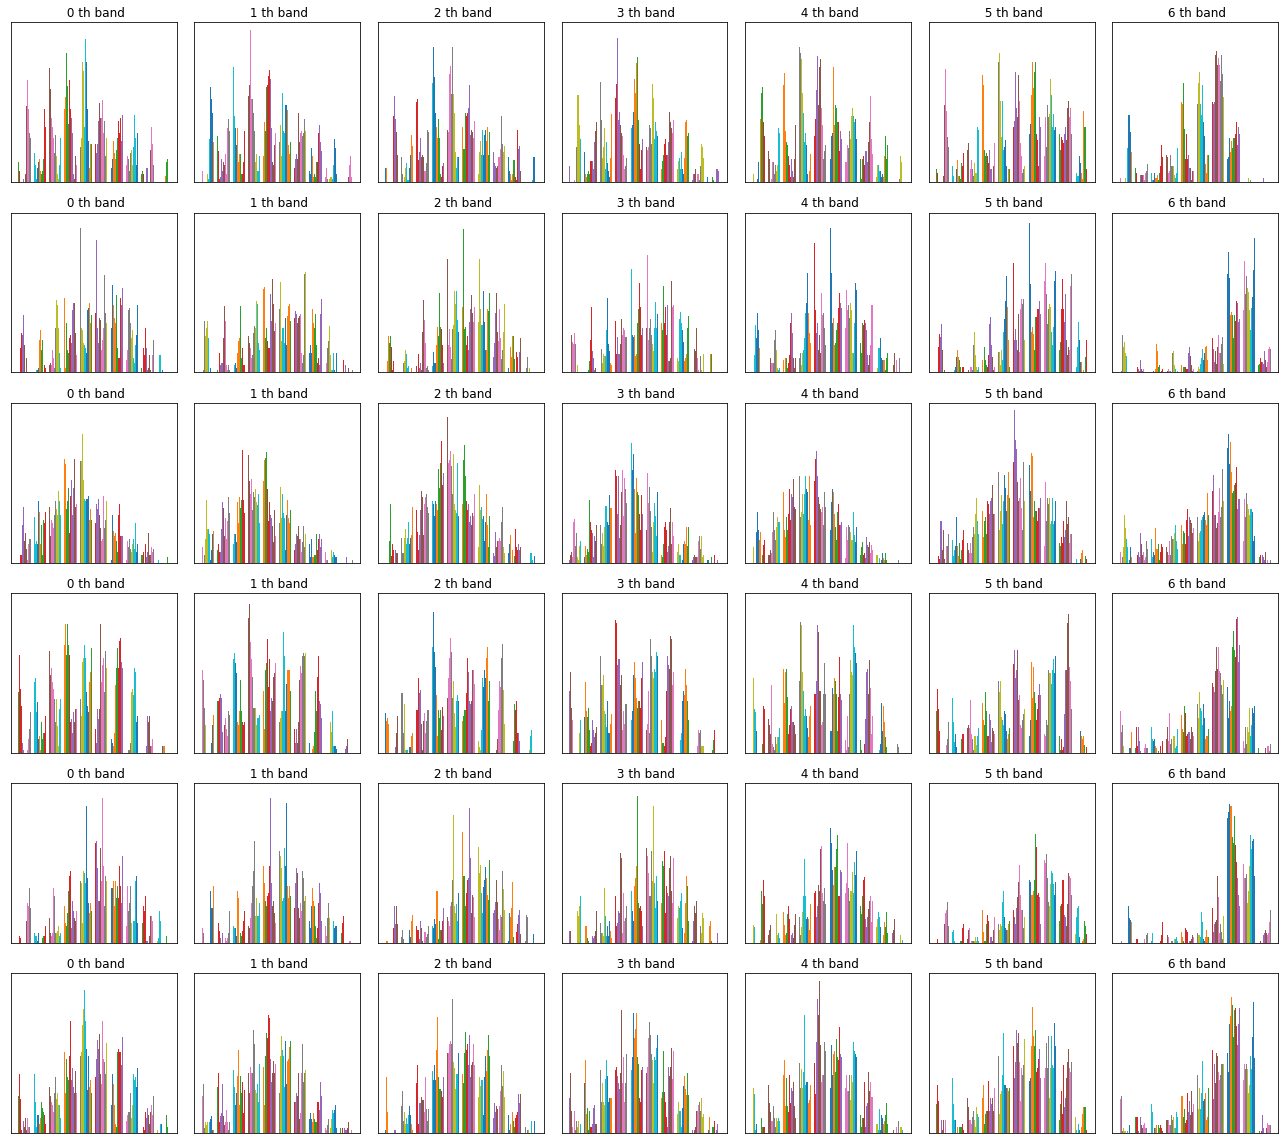

In [55]:
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(bc == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(bc == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(bc == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        plt.hist(_cimgs_array[i[0],:,:,ir])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

FFT for images

In [71]:
def get_spectrum(fft_array):
    # freq, ps
    freq = fftpack.fftfreq(fft_array.size)
    idx  = np.argsort(freq)
    ps   = np.abs(fft_array)**2 # poer spectrum 
    
    return freq, ps, idx

6


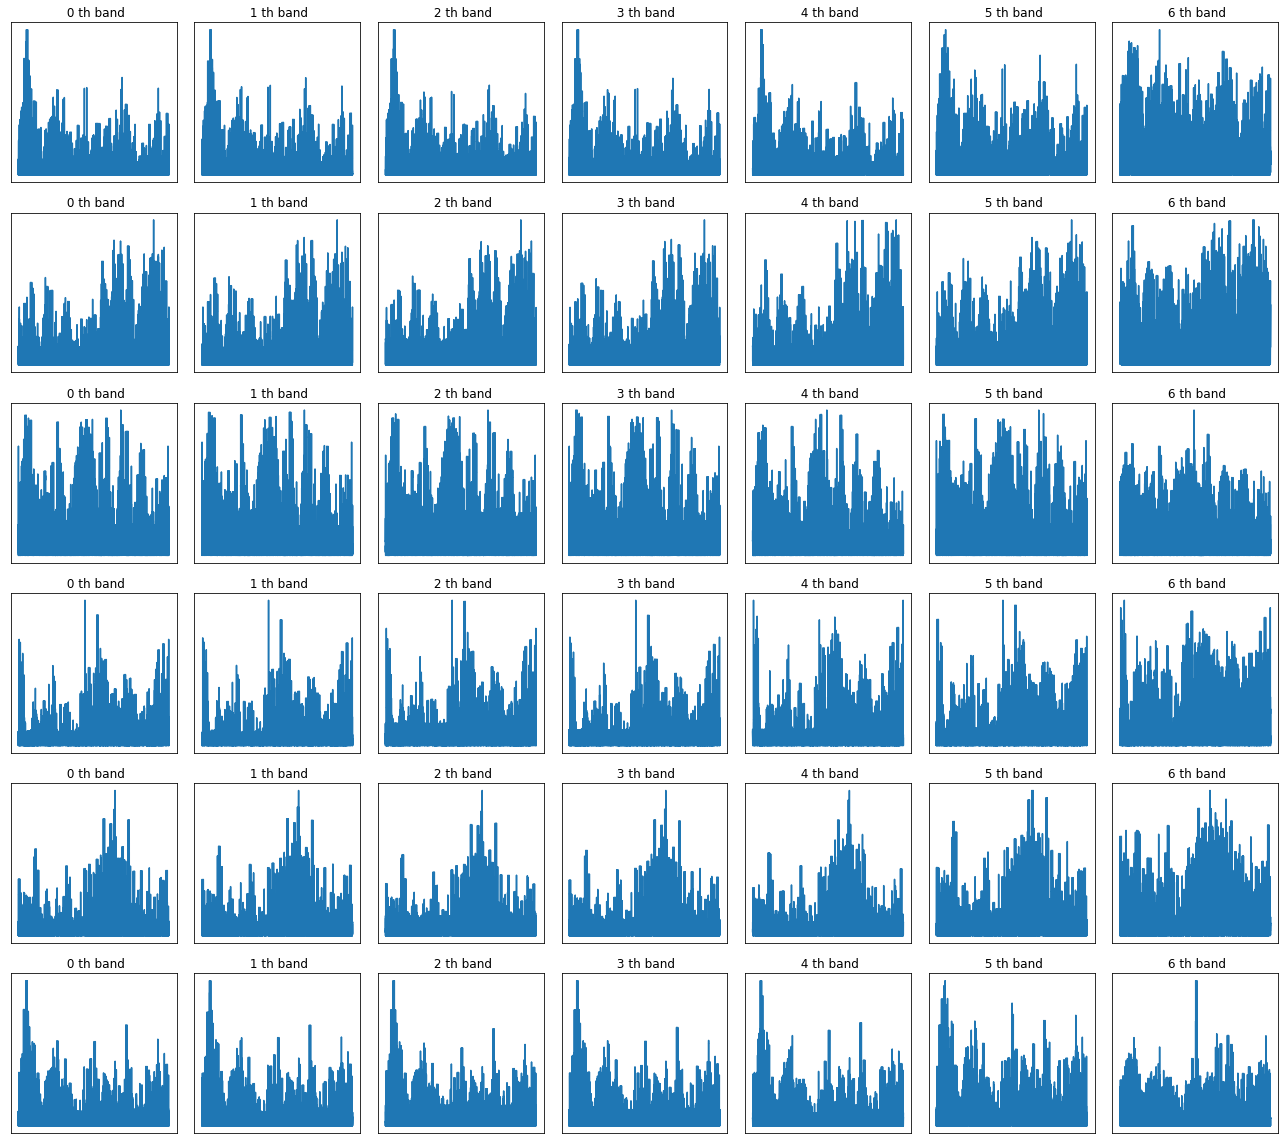

In [72]:
# power spectrum
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(o == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(o == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(o == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        tmp = oimgs_array[i[0],:,:,ir]
        freq, ps, idx = get_spectrum(tmp.flatten())
        plt.plot(freq[idx], ps[idx])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

6


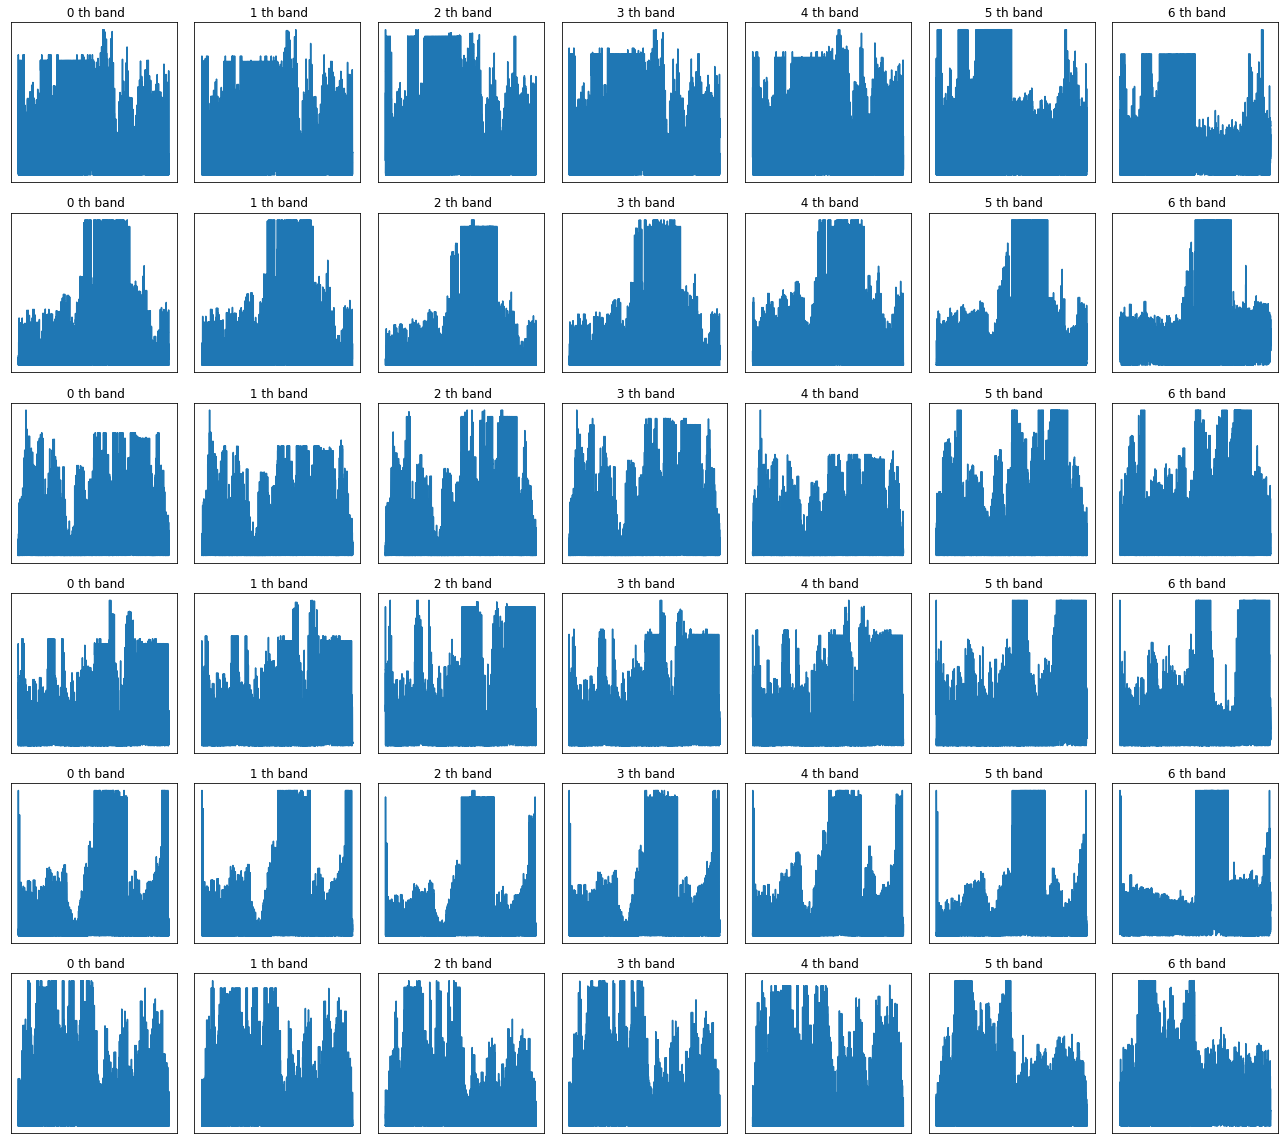

In [73]:
# power spectrum
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(bc == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(bc == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(bc == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        tmp = _cimgs_array[i[0],:,:,ir]
        freq, ps, idx = get_spectrum(tmp.flatten())
        plt.plot(freq[idx], ps[idx])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

When analyzed by FFT, original images in opens and closed analogues have little bit similar bimodal like distribution. Is this key points??

### Another cluster: cluster  2

9


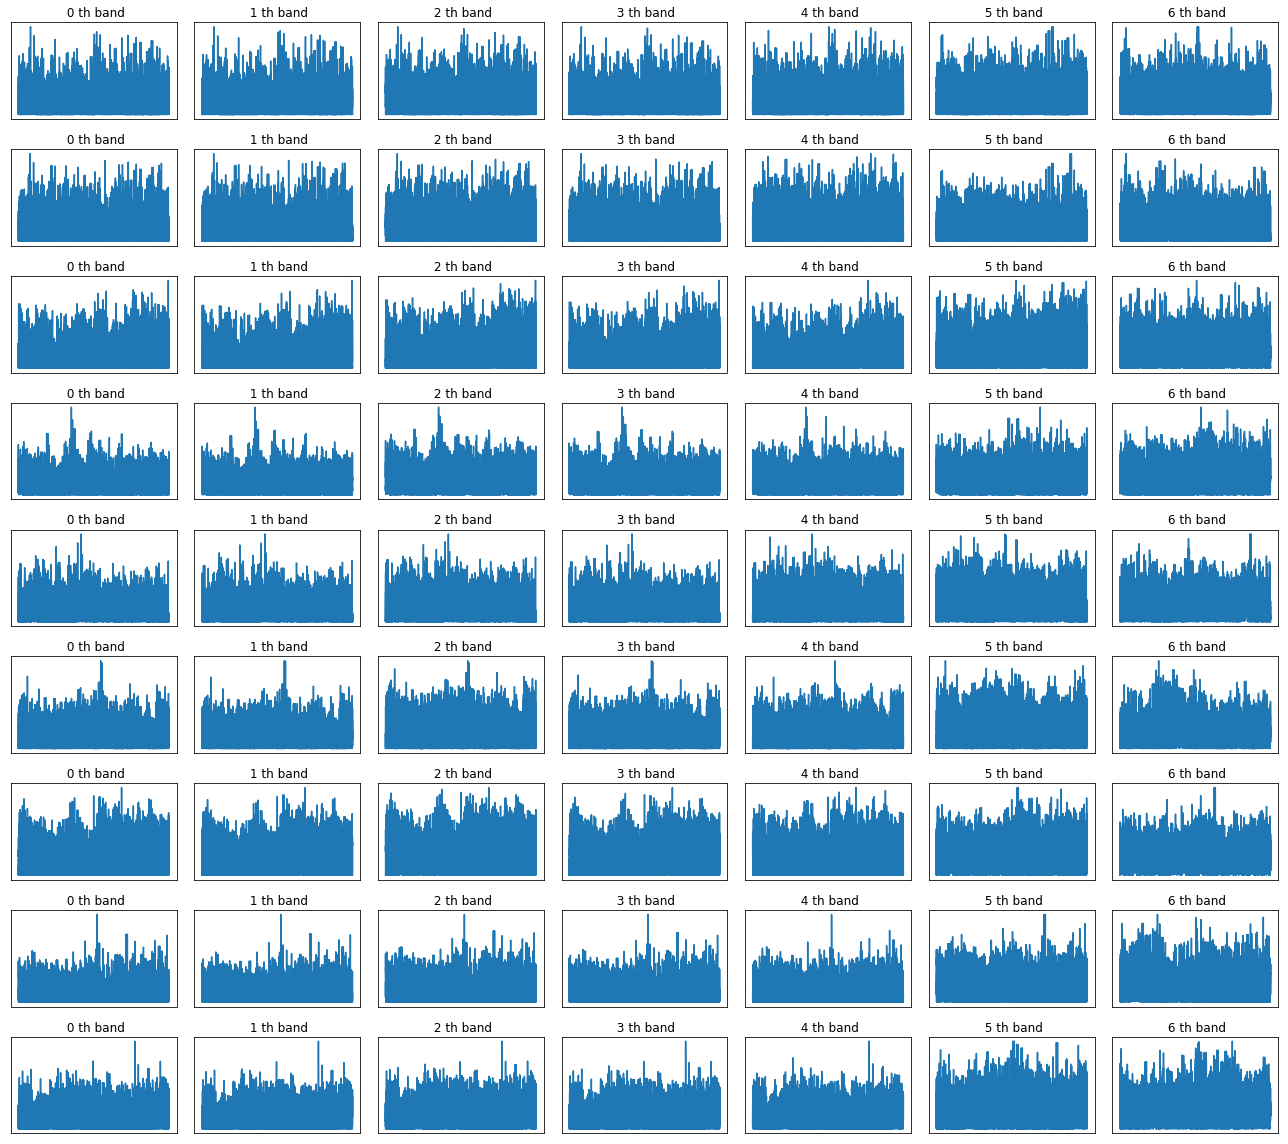

In [76]:
# power spectrum
fig = plt.figure(figsize=(18,16))
cluster = 2
print(len(np.argwhere(c == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(c == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(c == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        tmp = cimgs_array[i[0],:,:,ir]
        freq, ps, idx = get_spectrum(tmp.flatten())
        plt.plot(freq[idx], ps[idx])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

12


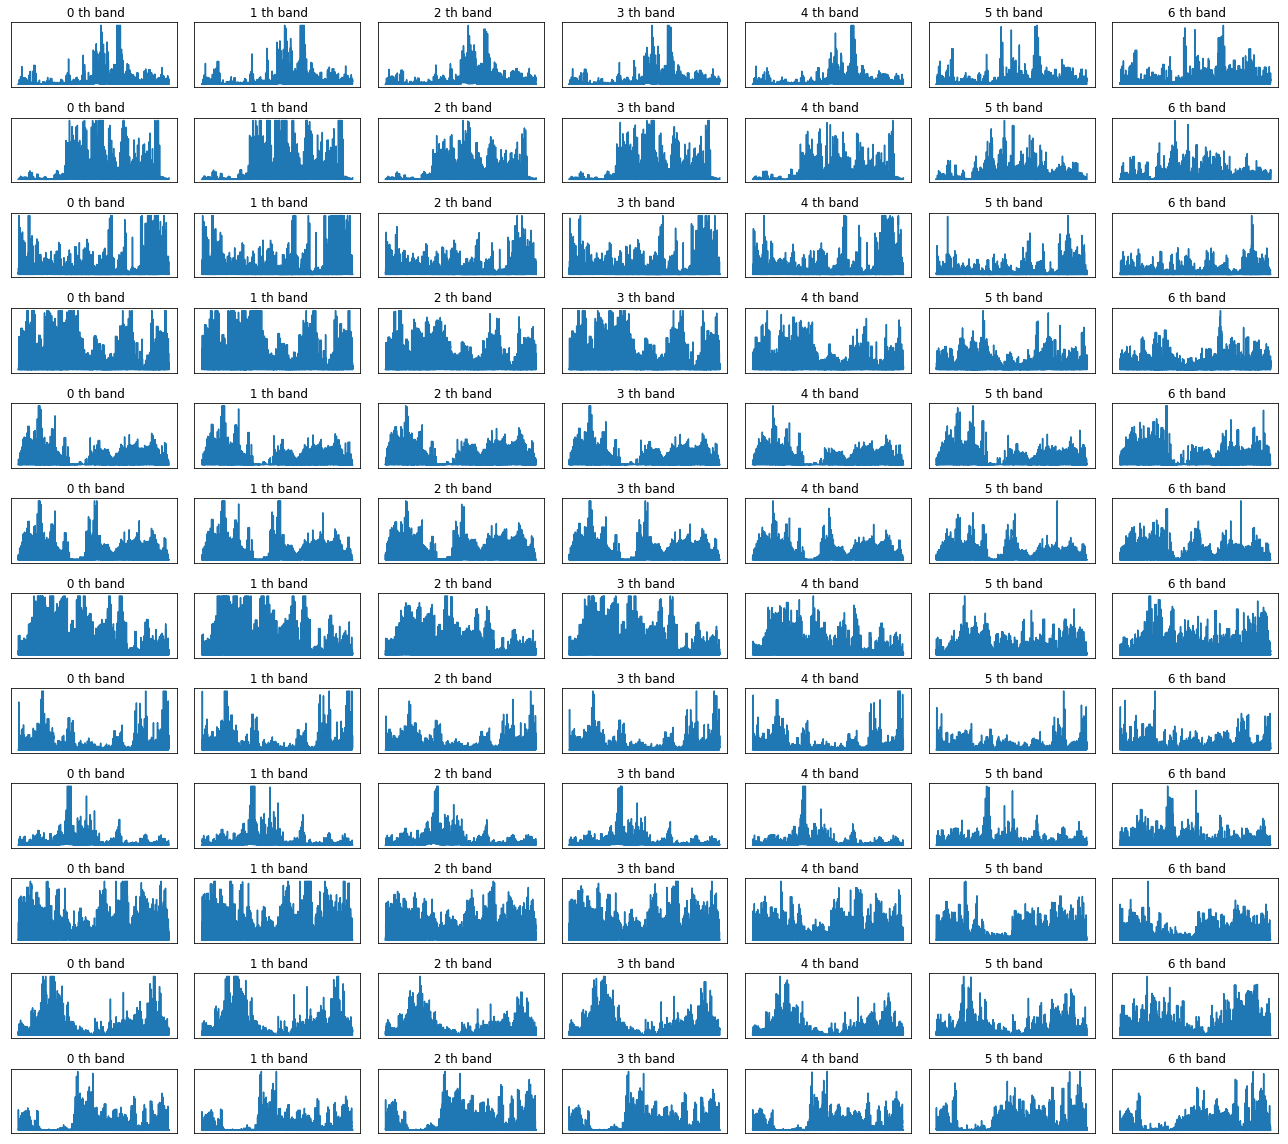

In [78]:
# power spectrum
fig = plt.figure(figsize=(18,16))
cluster = 2
print(len(np.argwhere(bo == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(bo == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(bo == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        tmp = _oimgs_array[i[0],:,:,ir]
        freq, ps, idx = get_spectrum(tmp.flatten())
        plt.plot(freq[idx], ps[idx])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

In contrast, FFT has no similar points in cluster 2 (and 0)

Try PCA

In [91]:
from sklearn.decomposition import PCA

In [92]:
pca = PCA(n_components=2)

In [96]:
closeds.encs.shape

(30, 128)

In [93]:
pca.fit(closeds.encs)
transformed = pca.fit_transform(closeds.encs)

In [97]:
transformed.shape

(30, 2)

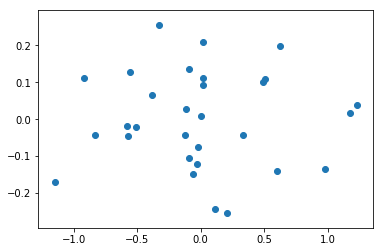

In [98]:
plt.scatter(transformed[:,0], transformed[:,1])

In [99]:
pca.fit(bopens.encs)
transformed = pca.fit_transform(bopens.encs)

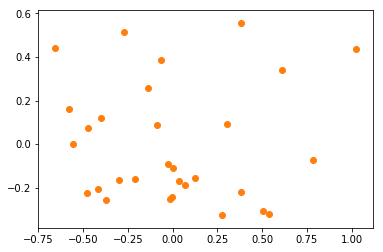

In [100]:
plt.scatter(transformed[:,0], transformed[:,1], color='#ff7f0e')

In [101]:
_data = np.append(closeds.encs, opens.encs, axis=0)

In [104]:
print(_data.shape) # check IO
pca.fit(_data)
transformed = pca.fit_transform(_data)

(60, 128)


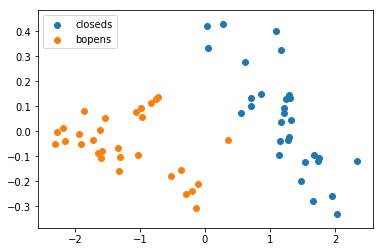

In [109]:
for ix, label in enumerate(['closeds', 'bopens']):
    if ix ==0:
        plt.scatter(transformed[:30,0], transformed[:30,1], label=label)
    else:
        plt.scatter(transformed[30:,0], transformed[30:,1], label=label)
plt.legend(loc='upper left')

In [110]:
pca.explained_variance_ratio_

array([0.94481844, 0.01542851], dtype=float32)

2


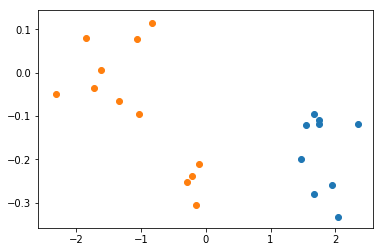

In [116]:
# PCA only for target cluster
print(cluster)
for ix, label in enumerate(['closeds', 'bopens']):
    if ix ==0:
         for j in  np.argwhere(c == cluster):
            plt.scatter(transformed[j[0],0], transformed[j[0],1], label=label, color='#1f77b4')
    else:
         for  l in np.argwhere(bo == cluster): 
            plt.scatter(transformed[30+l[0],0], transformed[30+l[0],1], label=label, color='#ff7f0e')
#plt.legend(loc='upper left')

In [115]:
lens= [len(np.argwhere(c == cluster)),
 len(np.argwhere(o == cluster)),
 len(np.argwhere(bc == cluster)),
 len(np.argwhere(bo == cluster))]
print(lens)

[9, 0, 0, 12]


PCA to latent space may not work for understanding the k-means classification

EMD in same cluster
--> EMD is applied to measure analogus of images 

# EMD 

**This EMD analysis is wrong but preserve for future intuition**

12/12 Casper's advice
EMD should be argued on the Probability distribution, not vector

Firstly, recall Cluster histogram

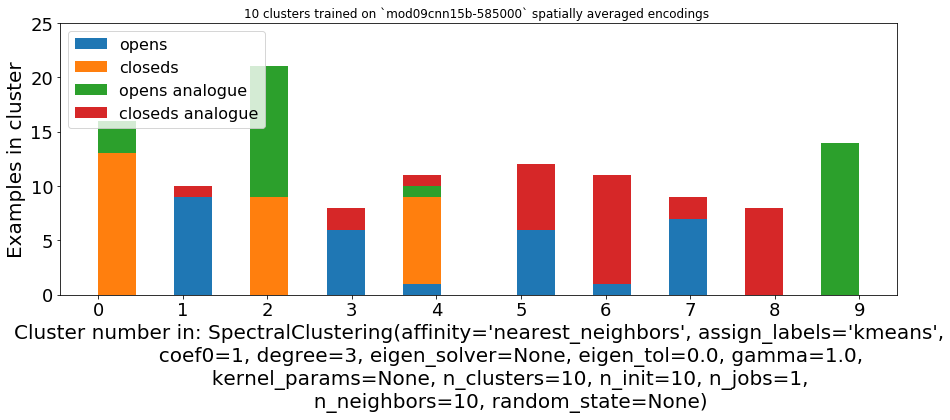

In [120]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([0,5,10,15,20, 25])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)

### intra class between 0 vs 2 

Closeds vs Opens analogue

In [140]:
current_cluster = 0
## get distribution of latent vector
# get index
cid = np.argwhere(c==current_cluster)
boid = np.argwhere(bo==current_cluster)
# get latent list
clatent_list, bolatent_list = [], []
for i in cid:
    clatent_list += [closeds.encs[i[0]]]
for j in boid:
    bolatent_list += [bopens.encs[j[0]]]

In [141]:
emd = [wasserstein_distance(x,y) for x in clatent_list for y in bolatent_list if x is not y ]

Text(0.5,1,'cluster No.0 Closeds vs Opens analogue ')

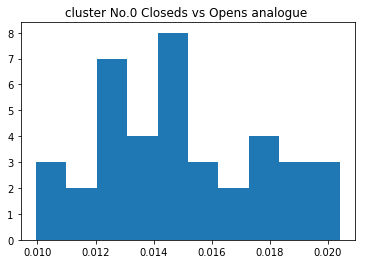

In [143]:
plt.hist(emd)
plt.title('cluster No.0 Closeds vs Opens analogue ')

In [136]:
current_cluster = 2
## get distribution of latent vector
# get index
cid = np.argwhere(c==current_cluster)
boid = np.argwhere(bo==current_cluster)
# get latent list
clatent_list, bolatent_list = [], []
for i in cid:
    clatent_list += [closeds.encs[i[0]]]
for j in boid:
    bolatent_list += [bopens.encs[j[0]]]

In [137]:
emd = [wasserstein_distance(x,y) for x in clatent_list for y in bolatent_list if x is not y ]

Text(0.5,1,'cluster No.2 Closds vs Opens analogue ')

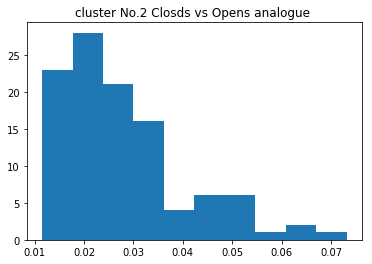

In [139]:
plt.hist(emd)
plt.title('cluster No.2 Closds vs Opens analogue ')

### intra clusters in 3 permutation types
closds-closeds / closeds-opens analogue / opens analogue-opens analogue

In [146]:
def _gen_emds(current_cluster, xcluster, ycluster, x_ae, y_ae):
    xid = np.argwhere(xcluster==current_cluster)
    yid = np.argwhere(ycluster==current_cluster)
    # get latent list
    x_list, y_list = [], []
    for i in xid:
        x_list += [x_ae.encs[i[0]]]
    for j in yid:
        y_list += [y_ae.encs[j[0]]]
    return x_list, y_list

In [147]:
c0_closeds, c0_bopens = _gen_emds(0, c,bo, closeds, bopens)

In [148]:
c2_closeds, c2_bopens = _gen_emds(2, c,bo, closeds, bopens)

In [163]:
emd1 = [wasserstein_distance(x,y) for x in c0_closeds for y in c2_closeds if x is not y ]

In [164]:
emd2 = [wasserstein_distance(x,y) for x in c0_closeds for y in c0_bopens if x is not y ]

In [165]:
emd3 = [wasserstein_distance(x,y) for x in c2_closeds for y in c2_bopens if x is not y ]

In [166]:
emd4 = [wasserstein_distance(x,y) for x in c0_bopens for y in c2_bopens if x is not y ]

In [177]:
emd5 = [wasserstein_distance(x,y) for x in c0_closeds for y in c2_bopens if x is not y ]

In [181]:
emd6 = [wasserstein_distance(x,y) for x in c2_closeds for y in c0_bopens if x is not y ]

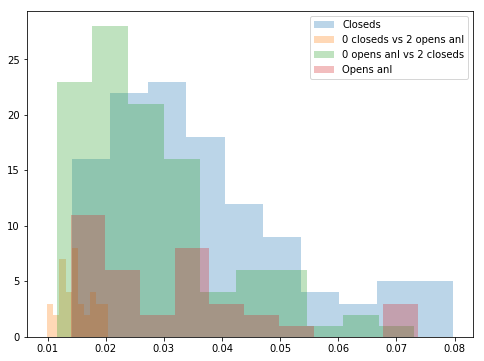

In [174]:
plt.figure(figsize=(8,6))
for i, label in zip([emd1, emd2, emd3, emd4], 
                    ['Closeds', '0 closeds vs 2 opens anl', '0 opens anl vs 2 closeds', 'Opens anl'] ):
    plt.hist(i, alpha=0.3, label=str(label))
plt.legend(loc='upper right')
plt.show()

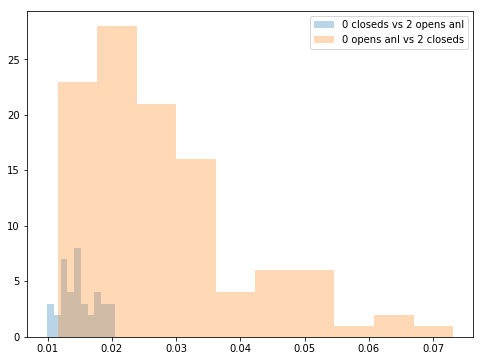

In [175]:
plt.figure(figsize=(8,6))
for i, label in zip([emd2, emd3], 
                    [ '0 closeds vs 2 opens anl', '0 opens anl vs 2 closeds'] ):
    plt.hist(i, alpha=0.3, label=str(label))
plt.legend(loc='upper right')
plt.show()

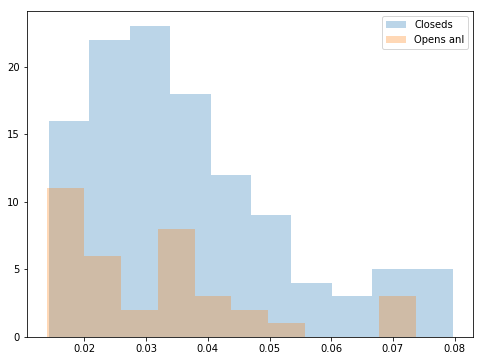

In [176]:
plt.figure(figsize=(8,6))
for i, label in zip([emd1, emd4], 
                    ['Closeds', 'Opens anl'] ):
    plt.hist(i, alpha=0.3, label=str(label))
plt.legend(loc='upper right')
plt.show()

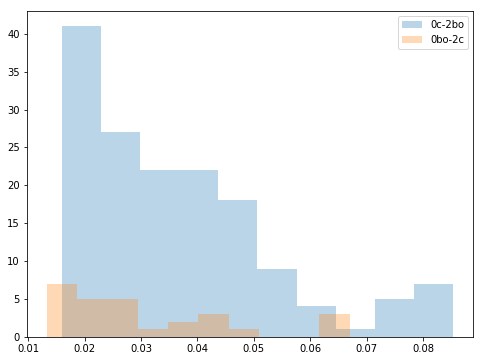

In [182]:
plt.figure(figsize=(8,6))
for i, label in zip([emd5, emd6], 
                    ['0c-2bo', '0bo-2c'] ):
    plt.hist(i, alpha=0.3, label=str(label))
plt.legend(loc='upper right')
plt.show()

==MEMO==
Given encoder or deep neural nets are sensitive towards object's shape, EMD(how close or far a pair of images) could work well.
Important point is how to connect cluster class and this metric

## intra classes among same image type

In [184]:
for i in range(num_clusters):
    print(" Current cluster == %d" %i)

 Current cluster == 0
 Current cluster == 1
 Current cluster == 2
 Current cluster == 3
 Current cluster == 4
 Current cluster == 5
 Current cluster == 6
 Current cluster == 7
 Current cluster == 8
 Current cluster == 9


# Upgrade Cluster number 

In [42]:
#  cluster
k.cluster_centers_ = centers
# Number of Clusters 
num_clusters = 20
# Append
oc = np.append(opens.encs,closeds.encs, axis=0)
boc = np.append(bopens.encs,bcloseds.encs, axis=0)
both = np.append(oc, boc,  axis=0)

In [43]:
method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = method.fit_predict(both)
o, c, bo, bc = clusters[:N], clusters[N:N*2], clusters[N*2:N*3], clusters[N*3:]

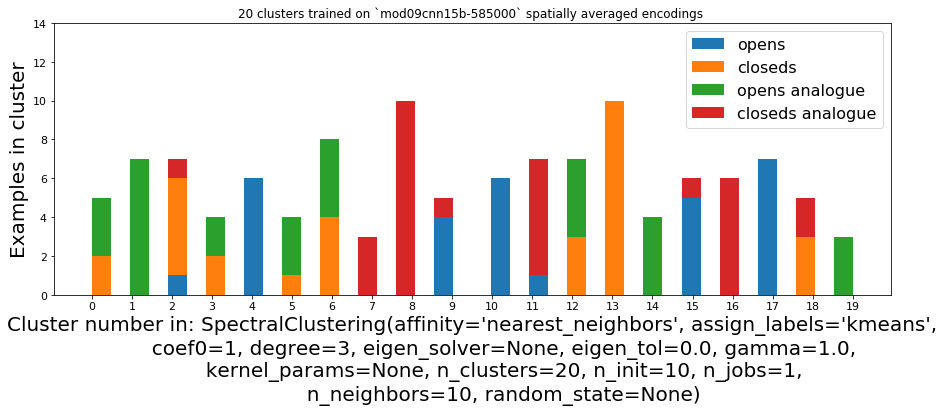

In [45]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([x for x in range(0,16,2)])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper right')
plt.tick_params(labelsize=11)

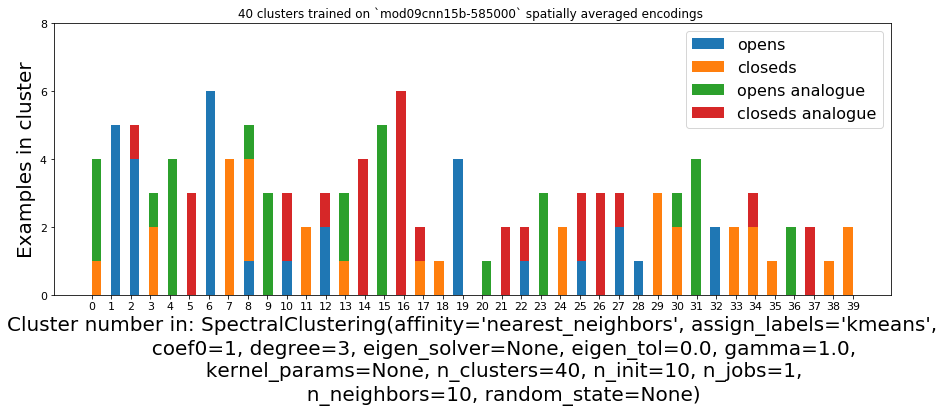

In [41]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([x for x in range(0,10,2)])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper right')
plt.tick_params(labelsize=11)

# Sensitivity Check based on bands

Now. 7 bands have distinct radiance information.
Next, let's create one radiance band only 7 depth dataset, and then compare difference for check where is the most sensitivity layer to this classification or all layers are equally contributing to the result.